Relevant Packages: pandas, numpy, matplotlib, statsmodels, pandas_datareader, yfinance, sklearn, PyPortfolioOpt

## Import Data + Packages

In [1]:
# Packages

# Data Wrangling
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Statistical Libraries
import random
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import warnings
import datetime as dt

# Finance Libraries
import pandas_ta
import yfinance as yf


# Portfolio Optimization Libraries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


import import_ipynb
from AT_Setup import create_stocks_df, test_strategy, SMA_Backtester
warnings.filterwarnings('ignore')


importing Jupyter notebook from AT_Setup.ipynb


In [2]:
sp500_df, stocks_df = create_stocks_df('2011-01-01','2024-05-22',500)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
stocks_df = stocks_df.reset_index().set_index(['Date','company'])

In [4]:
stocks_df.head(5)

,,Open,High,Low,Close,Adj Close,Volume
Date,company,,,,,,
2011-01-03,FSLR,131.850006,133.199997,131.729996,132.779999,132.779999,1079000.0
2011-01-04,FSLR,133.500000,133.509995,130.419998,131.119995,131.119995,1106600.0
2011-01-05,FSLR,130.520004,132.699997,130.240005,131.600006,131.600006,806000.0
2011-01-06,FSLR,131.949997,135.839996,131.000000,134.529999,134.529999,1477700.0
2011-01-07,FSLR,135.500000,135.500000,132.399994,133.580002,133.580002,718600.0


## Create Features

Features:
* **Garman-Klass Volatility** 
    * G-K Volatility is an estimator of volatility, taking into account the opening and closing price. Garman and Klaus created this metric with the assumption that price change is the result of continuous diffusion, or geometric Brownian motion. This method has the drawback of not being robust to opening jumps in prices and trend movements
    * **Rodgers-Satchell** volatility is recommended as a more useful volatility metric (worth exploring)
    * [Further exploration](https://portfoliooptimizer.io/blog/range-based-volatility-estimators-overview-and-examples-of-usage/#fn:21)
* **RSI** 
    * Relative Strength Index (RSI) is a momentum indicator that measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security
    * Is a strong signal for buying or selling, especially for short-term traders. Higher than 70 means overbought, lower than 30 is oversold. 
    * Overbought refers to a security that trades at a price level above its true (or intrinsic) value. Traders who see indications that a security is overbought may expect a price correction or trend reversal. Therefore, they may sell the security.
    * Oversold means the security is undervalued and traders, expecting a price reversal, purchase the security
    * Drawbacks: Signals must be in line with long term trend, and is most useful in an oscillating market (a trading range) where the asset price is alternating between bullish and bearish movements
    * The default look-back period for RSI is 14, but you can lower it to increase sensitivity or raise it to decrease sensitivity. A 10-day RSI is more likely to reach overbought or oversold levels than a 20-day RSI. The look-back parameters also depend on a security's volatility. The 14-day RSI for a volatile stock such as Amazon (AMZN) is more likely to become overbought or oversold than a 14-day RSI for a utility company such as Duke Energy (DUK).
* **Bollinger Bands** 
    * Bollinger Bands are another momentum indicator that gauge a stock's volatility to determine if a stock is overbought or overvalued. The default look-back period is 20 days.
    * It uses a simple moving average (SMA) and the statistical measure of standard deviation to assess the volatility and trends of stock prices.
    * The three lines that make up Bollinger Bands are based on a security's price moves. The center line is the intermediate-term trend and is typically a 20-day SMA of the closing prices. The upper and lower bands are plotted a distance from the SMA set by a certain number of standard deviations, usually two, above and below the center line.
    * The direction of the middle band can indicate a trend's strength: when the middle band is heading upward, this suggests an uptrend, and the converse when heading downward. In addition, the width of the bands reflects market volatility. Narrow bands indicate less volatility, which means a significant price move could be imminent. This is known as a "squeeze." Conversely, wide bands indicate more volatility.
    * With the upper band, you can look for overbought conditions, check for potential price reversals or a slowdown in momentum, find out when volatility is expanding, set price targets based on mean reversion strategies, and determine the strength of a trend. The lower band of the Bollinger Bands helps identify oversold conditions.
    * Drawback: This is a lagging indicator, less a predictive one, you should use this with other variables
* **ATR** 
    * Average True Range (ATR) measures market volatility by decomposing the entire range of an asset price for that period
    * The true range indicator is taken as the greatest of the following: current high less the current low; the absolute value of the current high less the previous close; and the absolute value of the current low less the previous close. The ATR is then a moving average, generally using **14 days**, of the true ranges
    * A stock with a high level of volatility has higher ATR, and low volatility has low ATR. It is mainly used for an exit method.
    * Drawbacks: ATR is subjective and more open to interpretation, and it only measures volatility and not the **directon** of the asset's price. Ultimately, it is best used to determine how much an investment's price has been moving in the period being evaluated rather than an indication of a trend. 
* **MACD** 
    * Moving average convergence/divergence (MACD) is a lagging indicator that helps investors identify market entry points for buying and selling. It is a trend-following momentum indicator that shows the relationship between two **exponential moving averages (EMA)** of a security's price
    * It is typically calculated by subtracting the 26 day EMA from the 12 day EMA, placing stronger emphasis on the more recent data.
    * The signal line is a 9-day EMA of the MACD line.
    * The MACD lines, however, do not have concrete overbought/oversold levels like the RSI and other oscillator studies. Rather, they function on a relative basis. An investor or trader should focus on the level and direction of the MACD/signal lines compared with preceding price movements in the security at hand
    * As shown on the following chart, when MACD falls below the signal line, it is a bearish signal indicating that it may be time to sell. Conversely, when MACD rises above the signal line, the signal is bullish, suggesting that the asset's price might experience upward momentum.
    * When MACD forms highs or lows that exceed the corresponding highs and lows on the price, it is called a divergence. A bullish divergence appears when MACD forms two rising lows that correspond with two falling lows on the price. This is a valid bullish signal when the long-term trend is still positive.
    * Drawbacks: moving average divergence can signal a possible reversal, but no actual reversal produces a false positive; you should confirm with other trend-following indicators like the Average Directional Index (ADX). The ADX is designed to indicate whether a trend is in place, with a reading above 25 indicating a trend is in place (in either direction) and a reading below 20 suggesting no trend is in place.
* **Dollar Volume**
    * Dollar Volume is the stock's share price times the DAILY volume
    * A stock is highly liquid if there is a high level of investor interest. Stocks with high liquidity, especially volume, tend to have tighter bid-ask spreads. This helps reduce the costs associated with trading. High dollar volume liquidity also tends to lead to reduced spreads, but in some cases, it may not.
    * A low-priced stock can do really high volume resulting in high dollar liquidity. A high-priced stock can do low volume, resulting in low dollar liquidity. Therefore, traders may look at both volume and dollar volume to assess the attractiveness of a stock.
    * High dollar volume liquidity is generally a positive sign, meaning there is significant interest in the stock. However, some investors that employ certain strategies, such as trying to get into a stock before it becomes popular, might prefer stocks with low dollar volume liquidity. A stock can also have high dollar volume while it is falling in value, mainly because falling prices can result in panic selling which drives up the volume.
    * Example: Apple Inc. (AAPL) is attractive for its liquidity. Assume it trades at $200 and its daily average volume is 27 million. The dollar volume liquidity is $5.4 billion. Despite the higher price, the spread is still tight and the high volume and dollar volume make it attractive from a liquidity perspective.

G-K Volatility = (ln(High) - ln(Low))**2 / 2 - (2*ln(2) - 1)(ln(Adj Close) - ln(Open))**2

In [5]:
stocks_df['GK Volatility'] = ((np.log(stocks_df['High']) - np.log(stocks_df['Low']))**2 / 2) - \
                             ((2 * np.log(2) - 1) * (np.log(stocks_df['Adj Close']) - np.log(stocks_df['Open']))**2)

In [6]:
# Relative Strength Indicator
stocks_df['RSI'] = stocks_df.groupby(by='company')['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))

In [7]:
stocks_df['BB_Low'] = stocks_df.groupby(by='company')['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)
                                                                                                        ,length=20).iloc[:,0])
stocks_df['BB_Mid'] = stocks_df.groupby(by='company')['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)
                                                                                                        ,length=20).iloc[:,1])
stocks_df['BB_Upper'] = stocks_df.groupby(by='company')['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x)
                                                                                                        ,length=20).iloc[:,2])

In [8]:
stocks_df

,,Open,High,Low,Close,Adj Close,Volume,GK Volatility,RSI,BB_Low,BB_Mid,BB_Upper
Date,company,,,,,,,,,,,
2011-01-03,FSLR,131.850006,133.199997,131.729996,132.779999,132.779999,1079000.0,0.000042,NaN,NaN,NaN,NaN
2011-01-04,FSLR,133.500000,133.509995,130.419998,131.119995,131.119995,1106600.0,0.000149,NaN,NaN,NaN,NaN
2011-01-05,FSLR,130.520004,132.699997,130.240005,131.600006,131.600006,806000.0,0.000149,NaN,NaN,NaN,NaN
2011-01-06,FSLR,131.949997,135.839996,131.000000,134.529999,134.529999,1477700.0,0.000513,NaN,NaN,NaN,NaN
2011-01-07,FSLR,135.500000,135.500000,132.399994,133.580002,133.580002,718600.0,0.000189,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-15,SBUX,75.900002,76.029999,75.320000,75.699997,75.129997,8826500.0,0.000004,32.024846,4.226484,4.391650,4.556815
2024-05-16,SBUX,75.190002,75.550003,74.459999,75.279999,75.279999,10758500.0,0.000105,32.533696,4.222098,4.384792,4.547486
2024-05-17,SBUX,75.269997,78.000000,74.919998,77.849998,77.849998,14436500.0,0.000373,40.558641,4.222113,4.379331,4.536549


In [9]:
def compute_atr(data):
    atr = pandas_ta.atr(high=data['High'], low = data['Low'], close = data['Close'], length = 14)
    # normalize
    return atr.sub(atr.mean()).div(atr.std())
    
stocks_df['ATR'] = stocks_df.groupby(by='company',group_keys=False).apply(compute_atr)

In [10]:
def compute_macd(data):
    macd = pandas_ta.macd(close = data['Close'], length = 20).iloc[:,0]
    # normalize
    return macd.sub(macd.mean()).div(macd.std())
    
stocks_df['MACD'] = stocks_df.groupby(by='company',group_keys=False).apply(compute_macd)

In [11]:
stocks_df['dollar_volume'] = (stocks_df['Adj Close'] * stocks_df['Volume']) / 1e6

## Aggregation, Find most Liquid Stocks

In [12]:
# Aggregate to Monthly Level

feature_cols = [x for x in stocks_df.columns if x not in ['Close','High','Low','Volume','Open','Close','dollar_volume']]
stocks_df.unstack()['dollar_volume'].resample('M').mean().stack().to_frame('Dollar Volume')

Dollar Volume
Date       company               
2011-01-31 A           121.995740
           AAL          68.747825
           AAPL       5533.970117
           ABT         419.639553
           ACGL         29.612816
...                           ...
2024-05-31 YUM         287.811952
           ZBH         164.717551
           ZBRA        102.243351
           ZION         61.881227
           ZTS         466.645575

[77163 rows x 1 columns]

In [13]:
stock_feature_df = pd.concat([stocks_df.unstack()[feature_cols].resample('M').last().stack(),
           stocks_df.unstack()['dollar_volume'].resample('M').mean().stack().to_frame('Dollar Volume')], axis=1)

In [14]:
stock_feature_df['Dollar Volume'] = stock_feature_df.loc[:,'Dollar Volume'].unstack().rolling(12*5,min_periods=12).mean().stack()

In [15]:
# Top 150 stocks by Dollar Volume
stock_feature_df["Dol_Vol_Rank"] = stock_feature_df.groupby('Date')['Dollar Volume'].rank(ascending=False)
stock_feature_df = stock_feature_df[stock_feature_df['Dol_Vol_Rank'] <= 150].drop(['Dol_Vol_Rank','Dollar Volume'],axis=1)

### Calculate Monthly Lags and Returns

In [16]:
def calculate_returns(data):
    # Monthly Lags
    lags = [1, 2, 3, 6, 9, 12]

    outlier_cutoff = 0.05

    for lag in lags:
        data[f'returns_{lag}m'] = (data['Adj Close'].pct_change(lag)\
                                .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),upper = x.quantile(1-outlier_cutoff)))\
                                .add(1).pow(1/lag).sub(1))
    return data

In [17]:
stock_feature_df = stock_feature_df.groupby(by='company',group_keys=False).apply(calculate_returns).dropna()


### FAMA-French Five Factor Model

In [18]:
factor_df = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start='2010')[0].drop('RF',axis=1)
factor_df.index = factor_df.index.to_timestamp()

In [19]:
factor_df = factor_df.resample('M').last().div(100)
factor_df

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2024-01-31,0.0070,-0.0574,-0.0238,0.0069,-0.0095
2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214
2024-03-31,0.0283,-0.0116,0.0420,0.0149,0.0117


In [20]:
# Merge with Stock Features to Evaluate 1 month returns
factor_df = factor_df.join(stock_feature_df['returns_1m'])

In [21]:
# Filter out stocks with < 12 months of data
min_months = 12
observations = factor_df.groupby('company').size()
valid_stocks = observations[observations >= min_months]
factor_df = factor_df[factor_df.index.get_level_values('company').isin(valid_stocks.index)]

### Calculate Rolling Factor Betas

Learn more [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html)

In [22]:
betas = factor_df.groupby(level=1,group_keys=False).apply(lambda x: RollingOLS(endog = x['returns_1m'],
                                                                          exog = sm.add_constant(x.drop('returns_1m',axis=1)),
                                                                          window = min(24,x.shape[0]), # 2 years
                                                                          min_nobs = len(x.columns) + 1)\
                                                                          .fit(params_only=True).params.drop('const',axis=1))

In [114]:
# Combine everything
stock_features_df = betas.groupby(by='company').shift().join(stock_feature_df)
stock_features_df

Mkt-RF       SMB       HML       RMW       CMA  \
Date       company                                                     
2012-12-31 A             NaN       NaN       NaN       NaN       NaN   
           AAPL          NaN       NaN       NaN       NaN       NaN   
           ABT           NaN       NaN       NaN       NaN       NaN   
           ACN           NaN       NaN       NaN       NaN       NaN   
           ADBE          NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
2024-03-31 VRTX     0.326973  0.593966 -0.882027  0.214473  1.150840   
           VZ       0.422064 -0.935361  0.652407  0.116367 -0.379494   
           WFC      1.075265  0.260720  1.157610 -0.256830 -0.992589   
           WMT      0.533009  0.067100 -0.555549  0.553616  0.685902   
           XOM      0.627800 -0.167832  0.352440  0.510780  0.344480   

                     Adj Close  GK Volatility        RSI    BB_Low    BB_Mid  \
Date       company                                                             
2012-12-31 A         26.582808  -1.127562e-03  59.466124  3.231251  3.289693   
           AAPL      16.211441  -4.057316e-03  44.756459  2.777556  2.844797   
           ABT       25.247690  -1.483704e-02  51.076478  3.247476  3.263925   
           ACN       54.118000  -1.391520e-02  44.317393  3.993034  4.043158   
           ADBE      37.680000   1.832088e-04  65.897910  3.567346  3.626436   
...                        ...            ...        ...       ...       ...   
2024-03-31 VRTX     418.010010   8.536321e-05  50.803478  6.005554  6.031164   
           VZ        41.291332   4.973622e-05  64.018258  3.675142  3.704789   
           WFC       57.628693   4.032754e-05  67.497305  4.032646  4.056539   
           WMT       59.962444  -7.863698e-07  58.957213  4.092355  4.115271   
           XOM      115.303452   7.061082e-05  73.762473  4.645190  4.706869   

                    BB_Upper       ATR      MACD  returns_1m  returns_2m  \
Date       company                                                         
2012-12-31 A        3.348135 -0.884205  0.232967    0.071830    0.067861   
           AAPL     2.912038 -0.670698 -0.505753   -0.090743   -0.052368   
           ABT      3.280374 -0.940179 -0.157338    0.007693    0.000000   
           ACN      4.093282 -0.782553 -0.305326   -0.020907   -0.006773   
           ADBE     3.685525 -0.912345 -0.002877    0.088703    0.052263   
...                      ...       ...       ...         ...         ...   
2024-03-31 VRTX     6.056774  0.983190 -0.553607   -0.006489   -0.017893   
           VZ       3.734437 -0.534462  0.505021    0.048476   -0.004615   
           WFC      4.080431  0.086736  1.389101    0.042634    0.078496   
           WMT      4.138187  0.637629  1.441209    0.030113    0.046931   
           XOM      4.768548  0.115110  2.217274    0.112132    0.068240   

                    returns_3m  returns_6m  returns_9m  returns_12m  
Date       company                                                   
2012-12-31 A          0.021970    0.007940   -0.008399     0.014159  
           AAPL      -0.064329   -0.013918   -0.012189     0.023771  
           ABT       -0.012714    0.005167    0.010052     0.015517  
           ACN       -0.013294    0.019000    0.005890     0.020618  
           ADBE       0.051179    0.025639    0.010465     0.024233  
...                        ...         ...         ...          ...  
2024-03-31 VRTX       0.009028    0.031150    0.019310     0.023839  
           VZ         0.042123    0.033753    0.019778     0.012408  
           WFC        0.058463    0.061971    0.037311     0.039950  
           WMT        0.047357    0.021589    0.016699     0.018226  
           XOM        0.054759    0.001149    0.011961     0.007816  

[19533 rows x 19 columns]

In [115]:
factors = ['Mkt-RF', "SMB", "HML", "RMW", "CMA"]
stock_features_df.loc[:, factors] = stock_features_df.groupby('company',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))


stock_features_df = stock_features_df.dropna()
stock_features_df = stock_features_df.drop('Adj Close',axis=1)

In [160]:
stock_features_df

Mkt-RF       SMB       HML       RMW       CMA  \
Date       company                                                     
2012-12-31 AAPL     1.148807 -0.139098 -0.334140  0.813238 -0.722154   
           ABT      0.967229 -0.167629 -0.542016  0.085821  0.519184   
           ACN      1.034633 -0.303823 -0.157387 -0.010272 -0.102809   
           ADBE     1.001966 -0.293745 -0.064841 -0.442386 -1.183759   
           AIG      1.059410 -0.478458  0.811050 -0.757229 -0.616228   
...                      ...       ...       ...       ...       ...   
2024-03-31 VRTX     0.326973  0.593966 -0.882027  0.214473  1.150840   
           VZ       0.422064 -0.935361  0.652407  0.116367 -0.379494   
           WFC      1.075265  0.260720  1.157610 -0.256830 -0.992589   
           WMT      0.533009  0.067100 -0.555549  0.553616  0.685902   
           XOM      0.627800 -0.167832  0.352440  0.510780  0.344480   

                    GK Volatility        RSI    BB_Low    BB_Mid  BB_Upper  \
Date       company                                                           
2012-12-31 AAPL     -4.057316e-03  44.756459  2.777556  2.844797  2.912038   
           ABT      -1.483704e-02  51.076478  3.247476  3.263925  3.280374   
           ACN      -1.391520e-02  44.317393  3.993034  4.043158  4.093282   
           ADBE      1.832088e-04  65.897910  3.567346  3.626436  3.685525   
           AIG      -1.895922e-02  55.642331  3.293171  3.337451  3.381730   
...                           ...        ...       ...       ...       ...   
2024-03-31 VRTX      8.536321e-05  50.803478  6.005554  6.031164  6.056774   
           VZ        4.973622e-05  64.018258  3.675142  3.704789  3.734437   
           WFC       4.032754e-05  67.497305  4.032646  4.056539  4.080431   
           WMT      -7.863698e-07  58.957213  4.092355  4.115271  4.138187   
           XOM       7.061082e-05  73.762473  4.645190  4.706869  4.768548   

                         ATR      MACD  returns_1m  returns_2m  returns_3m  \
Date       company                                                           
2012-12-31 AAPL    -0.670698 -0.505753   -0.090743   -0.052368   -0.064329   
           ABT     -0.940179 -0.157338    0.007693    0.000000   -0.012714   
           ACN     -0.782553 -0.305326   -0.020907   -0.006773   -0.013294   
           ADBE    -0.912345 -0.002877    0.088703    0.052263    0.051179   
           AIG     -0.741471  0.416478    0.065499    0.005282    0.024891   
...                      ...       ...         ...         ...         ...   
2024-03-31 VRTX     0.983190 -0.553607   -0.006489   -0.017893    0.009028   
           VZ      -0.534462  0.505021    0.048476   -0.004615    0.042123   
           WFC      0.086736  1.389101    0.042634    0.078496    0.058463   
           WMT      0.637629  1.441209    0.030113    0.046931    0.047357   
           XOM      0.115110  2.217274    0.112132    0.068240    0.054759   

                    returns_6m  returns_9m  returns_12m  cluster  
Date       company                                                
2012-12-31 AAPL      -0.013918   -0.012189     0.023771        0  
           ABT        0.005167    0.010052     0.015517        3  
           ACN        0.019000    0.005890     0.020618        0  
           ADBE       0.025639    0.010465     0.024233        1  
           AIG        0.016017    0.015158     0.034637        3  
...                        ...         ...          ...      ...  
2024-03-31 VRTX       0.031150    0.019310     0.023839        3  
           VZ         0.033753    0.019778     0.012408        1  
           WFC        0.061971    0.037311     0.039950        1  
           WMT        0.021589    0.016699     0.018226        3  
           XOM        0.001149    0.011961     0.007816        2  

[19300 rows x 19 columns]

## ML Models

### KMeans Clustering

In [116]:
# Notes: 
# Optimal # of clusters is around 4
# Initialize predefined centroids for each cluster based on your research

In [166]:
from sklearn.cluster import KMeans
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, random_state = 42, init = 'random').fit(df).labels_
    return df

stock_features_df = stock_features_df.groupby('Date',group_keys=False).apply(get_clusters)

In [171]:
stock_features_df.iloc[:,6:11]

RSI    BB_Low    BB_Mid  BB_Upper       ATR
Date       company                                                   
2012-12-31 AAPL     44.756459  2.777556  2.844797  2.912038 -0.670698
           ABT      51.076478  3.247476  3.263925  3.280374 -0.940179
           ACN      44.317393  3.993034  4.043158  4.093282 -0.782553
           ADBE     65.897910  3.567346  3.626436  3.685525 -0.912345
           AIG      55.642331  3.293171  3.337451  3.381730 -0.741471
...                       ...       ...       ...       ...       ...
2024-03-31 VRTX     50.803478  6.005554  6.031164  6.056774  0.983190
           VZ       64.018258  3.675142  3.704789  3.734437 -0.534462
           WFC      67.497305  4.032646  4.056539  4.080431  0.086736
           WMT      58.957213  4.092355  4.115271  4.138187  0.637629
           XOM      73.762473  4.645190  4.706869  4.768548  0.115110

[19300 rows x 5 columns]

In [172]:
def plot_clusters(df):
    cluster_0 = df[df['cluster'] == 0]
    cluster_1 = df[df['cluster'] == 1]
    cluster_2 = df[df['cluster'] == 2]
    cluster_3 = df[df['cluster'] == 3]
    # 6 is ATR, 11 is RSI
    x_axis = 6
    y_axis = 11
    plt.scatter(cluster_0.iloc[:,x_axis], cluster_0.iloc[:,y_axis],color='red',label = 'Cluster 0')
    plt.scatter(cluster_1.iloc[:,x_axis], cluster_1.iloc[:,y_axis],color='black',label = 'Cluster 1')
    plt.scatter(cluster_2.iloc[:,x_axis], cluster_2.iloc[:,y_axis],color='green',label = 'Cluster 2')
    plt.scatter(cluster_3.iloc[:,x_axis], cluster_3.iloc[:,y_axis],color='blue',label = 'Cluster 3')

    plt.legend()
    plt.show()
    return

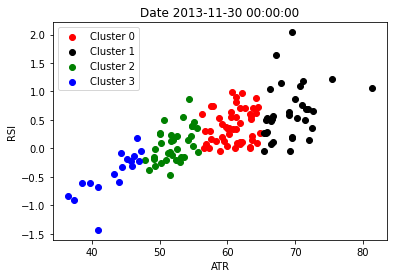

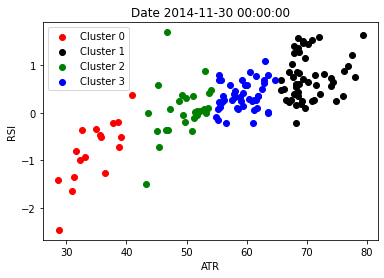

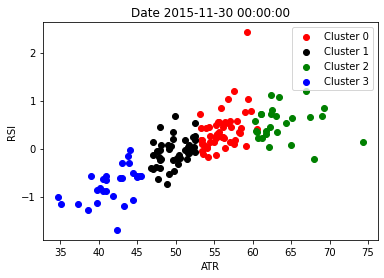

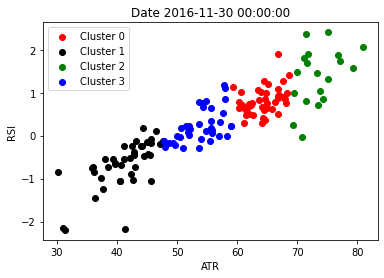

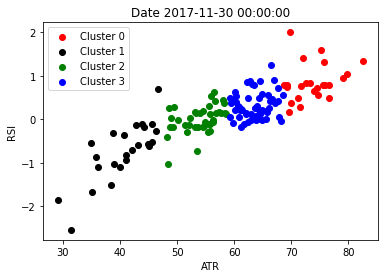

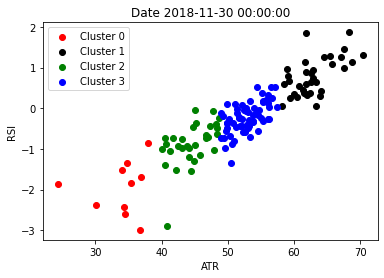

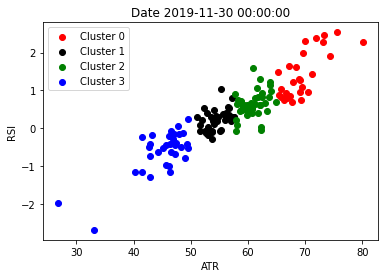

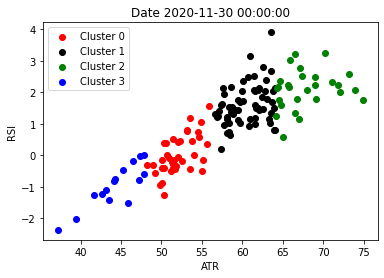

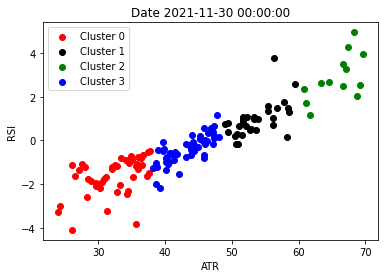

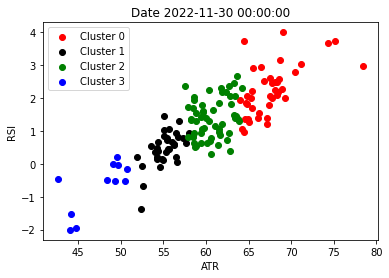

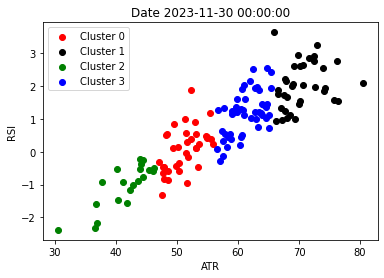

In [173]:
count = 0
for i in stock_features_df.index.get_level_values('Date').unique().tolist():
    g = stock_features_df.xs(i,level=0)
    count += 1
    if count % 12 == 0:
        plt.title(f'Date {i}')
        plt.xlabel("ATR")
        plt.ylabel("RSI")
        plot_clusters(g)

### Pre-Defined Centroids

In [174]:
# Must be shape (n_features, n_clusters)
initial_centroids = np.zeros((4,18))

### Target RSI Values

In [175]:
target_rsi_values = [30, 45, 55, 70]
initial_centroids[:, 11] = target_rsi_values
initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [176]:
def get_clusters_improved(df):
    df['cluster'] = KMeans(n_clusters = 4, random_state = 42, init = initial_centroids).fit(df).labels_
    return df
stock_features_df = stock_features_df.drop('cluster',axis=1)
stock_features_df = stock_features_df.groupby('Date',group_keys=False).apply(get_clusters_improved)

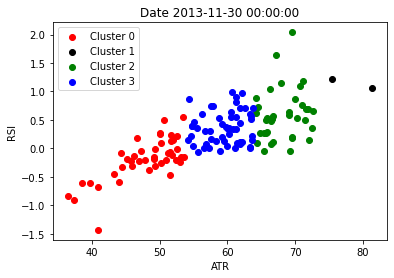

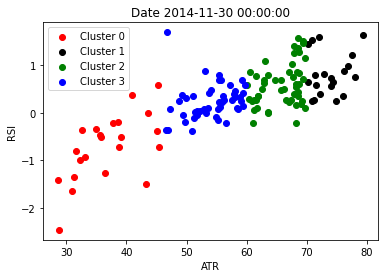

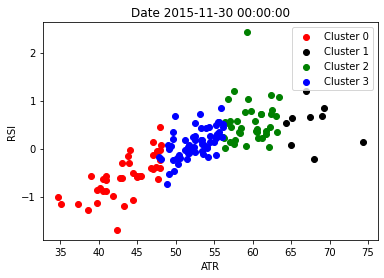

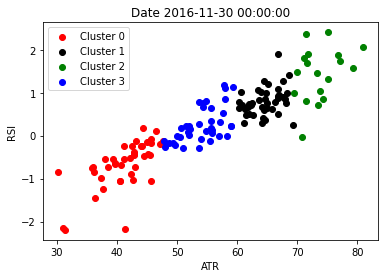

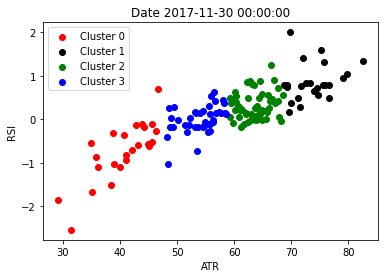

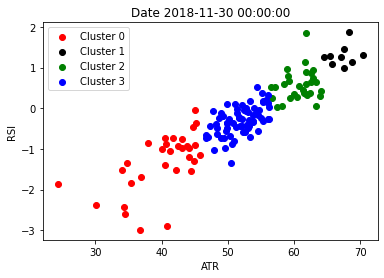

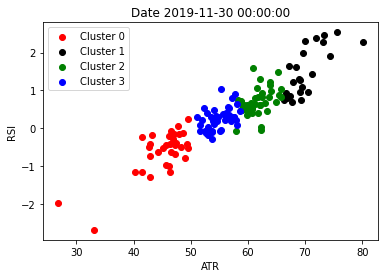

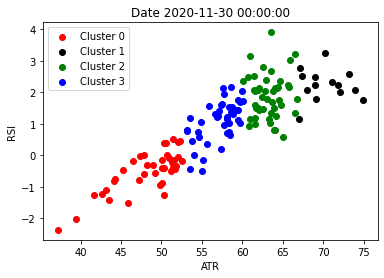

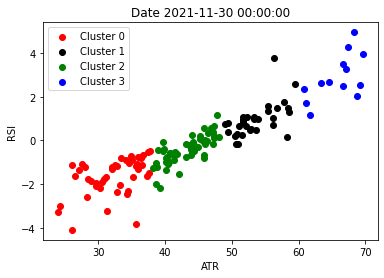

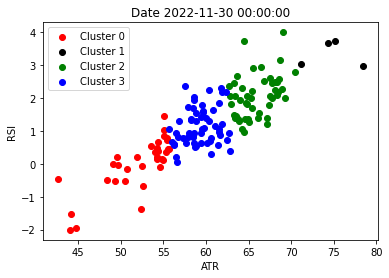

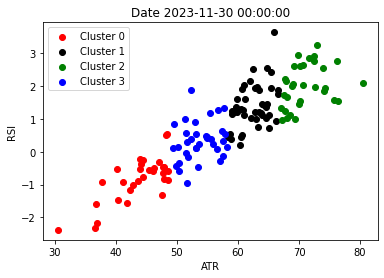

In [177]:
count = 0
for i in stock_features_df.index.get_level_values('Date').unique().tolist():
    g = stock_features_df.xs(i,level=0)
    count += 1
    if count % 12 == 0:
        plt.title(f'Date {i}')
        plt.xlabel("ATR")
        plt.ylabel("RSI")
        plot_clusters(g)
   # plot_clusters(g)

## Select stocks based off cluster, form portfolio based on Efficient Frontier max Sharp Ratio Optimization

Hypothesis: stocks clustered around RSI 70 will outperform in following month (Cluster 3)

In [178]:
max_rsi_df = stock_features_df[stock_features_df['cluster'] == 2]
max_rsi_df = max_rsi_df.reset_index(level=1)

In [179]:
max_rsi_df.index = max_rsi_df.index + pd.DateOffset(1)
max_rsi_df = max_rsi_df.reset_index().set_index(['Date','company'])

In [180]:
dates = max_rsi_df.index.get_level_values('Date').unique().tolist()
date_dict = {}

for date in dates:
    date_dict[date.strftime('%Y-%m-%d')] = max_rsi_df.xs(date,level=0).index.tolist()
    
date_dict

{'2013-01-01': ['BAC', 'F', 'GM'],
 '2013-02-01': ['ABT',
  'AIG',
  'BIIB',
  'BMY',
  'BRK-B',
  'CAT',
  'CF',
  'CSX',
  'CTSH',
  'DE',
  'DIS',
  'EMR',
  'FDX',
  'FFIV',
  'GOOG',
  'GOOGL',
  'HD',
  'HON',
  'IBM',
  'ISRG',
  'JNJ',
  'JNPR',
  'JPM',
  'LOW',
  'LVS',
  'MCD',
  'MCK',
  'MDLZ',
  'MDT',
  'MET',
  'MMM',
  'NSC',
  'NTAP',
  'ORCL',
  'PARA',
  'PEP',
  'PFE',
  'TRV',
  'TXN',
  'WBA',
  'WYNN'],
 '2013-03-01': ['ACN',
  'ADBE',
  'AMAT',
  'AXP',
  'BIIB',
  'BMY',
  'CMG',
  'CSX',
  'CVX',
  'DHR',
  'DIS',
  'DUK',
  'EXC',
  'FDX',
  'GE',
  'HAL',
  'HD',
  'HES',
  'HON',
  'JPM',
  'KO',
  'LLY',
  'MCK',
  'NKE',
  'PARA',
  'PFE',
  'PG',
  'PM',
  'PXD',
  'RTX',
  'T',
  'TMO',
  'TRV',
  'TXN',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WBA'],
 '2013-04-01': ['AMGN',
  'BIIB',
  'BMY',
  'DUK',
  'EXC',
  'GILD',
  'HON',
  'HPQ',
  'JNJ',
  'MDLZ',
  'TRV',
  'WBA'],
 '2013-05-01': ['ACN',
  'ADBE',
  'AMAT',
  'AMT',
  'AXP',
  'BA',
 

### Define Portfolio Optimization Function

In [181]:
def optimize_weights(prices):
    returns = expected_returns.mean_historical_return(prices = prices,
                                                     frequency = 252)
    cov = risk_models.sample_cov(prices = prices, frequency = 252)
    ef = EfficientFrontier(returns, cov, weight_bounds = (0, 0.25), solver = 'SCS')    
    return ef.clean_weights()

### Get Fresh Stock Data

In [182]:
stock_diff_df = stocks_df.dropna().unstack()['Adj Close']
stock_diff_df

company,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-08,28.396120,9.314286,10.725173,NaN,NaN,16.559908,10.097778,41.063625,33.570000,28.992720,...,14.839496,84.517639,49.450493,33.147293,NaN,27.797131,52.534477,40.209999,19.835154,NaN
2011-02-09,27.920393,9.314286,10.814549,NaN,NaN,16.534498,10.138889,41.110432,33.009998,29.131748,...,14.845602,85.467026,49.194267,32.535469,NaN,27.746687,52.017551,40.700001,19.741446,NaN
2011-02-10,28.286835,9.286004,10.705245,NaN,NaN,16.516335,10.123333,41.336655,33.570000,29.263462,...,15.095875,84.496529,49.581604,32.715408,NaN,27.881214,52.613335,40.950001,19.218235,NaN
2011-02-11,28.942581,9.549972,10.774989,NaN,NaN,16.541758,10.251111,40.876396,33.669998,29.702526,...,15.382773,90.790695,49.355148,32.949348,NaN,27.898022,53.121506,41.180000,19.491560,NaN
2011-02-14,28.794710,9.399133,10.845347,NaN,NaN,16.694242,10.126667,40.884205,33.860001,29.995247,...,15.156916,89.981956,50.600651,32.769405,NaN,28.195126,53.252930,41.099998,19.296324,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-15,154.080002,14.940000,189.720001,163.789993,145.800003,104.589996,97.870003,308.519989,485.350006,215.750000,...,31.360001,97.368690,118.580002,28.260000,143.789993,138.339996,120.980003,323.869995,45.099998,173.279999
2024-05-16,154.309998,14.790000,189.839996,164.350006,147.190002,104.870003,98.820000,308.000000,482.880005,214.119995,...,31.110001,96.860001,117.870003,28.379999,142.679993,141.660004,121.230003,319.859985,44.740002,173.710007
2024-05-17,154.229996,14.730000,189.869995,166.419998,145.660004,104.089996,100.989998,303.589996,483.429993,214.080002,...,31.170000,96.790001,119.639999,28.280001,143.320007,141.660004,120.180000,317.890015,44.959999,174.059998


In [183]:
stock_log_df = np.log(stock_diff_df).diff()

In [130]:
date_dict

{'2013-01-01': ['ABT',
  'AIG',
  'AMD',
  'AMZN',
  'APA',
  'AXP',
  'BA',
  'BAX',
  'BMY',
  'BRK-B',
  'CI',
  'CMCSA',
  'COF',
  'COP',
  'CVX',
  'DE',
  'DIS',
  'EBAY',
  'EOG',
  'FDX',
  'FFIV',
  'GE',
  'GILD',
  'GLW',
  'GOOG',
  'GOOGL',
  'HES',
  'HPQ',
  'INTC',
  'JNJ',
  'LLY',
  'LULU',
  'MA',
  'MCD',
  'MCK',
  'MET',
  'MMM',
  'MRO',
  'MU',
  'NEM',
  'NSC',
  'NVDA',
  'PFE',
  'PNC',
  'QCOM',
  'TMO',
  'TRV',
  'UNH',
  'UNP',
  'UPS',
  'WFC',
  'WYNN'],
 '2013-02-01': ['ACN',
  'ADBE',
  'APA',
  'BAX',
  'BK',
  'BKNG',
  'BKR',
  'C',
  'CCL',
  'CMG',
  'CMI',
  'COST',
  'CRM',
  'CSCO',
  'CVS',
  'CVX',
  'DHR',
  'DVN',
  'EBAY',
  'ELV',
  'EOG',
  'EXC',
  'GE',
  'GILD',
  'HPQ',
  'LLY',
  'MA',
  'MGM',
  'MO',
  'MOS',
  'MRO',
  'MU',
  'NKE',
  'PNC',
  'QCOM',
  'RTX',
  'SBUX',
  'SLB',
  'T',
  'TJX',
  'UNP',
  'UPS',
  'V',
  'WFC'],
 '2013-03-01': ['ABT',
  'AIG',
  'AMT',
  'AMZN',
  'BA',
  'BAX',
  'BK',
  'BKNG',
  'BKR',
  'C

In [184]:
returns_df = pd.DataFrame()

for start_date in date_dict.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    companies = date_dict[start_date]
    optimize_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimize_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    optimize_df = stock_diff_df[optimize_start_date:optimize_end_date][companies]
    failure = True
    try:
        weights = optimize_weights(optimize_df)
        weights = pd.DataFrame(weights, index = pd.Series(0))
        failure = False
    except:
        print(f"Max Sharpe Optimization failed for {start_date}")
    if failure:
        weights = pd.DataFrame([1/len(optimize_df.columns) for i in range(len(optimize_df.columns))],
                               index = optimize_df.columns.tolist(),
                               columns = pd.Series(0)).T
    log_df = stock_log_df[start_date:end_date]
    log_df = log_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').\
                                                                         reset_index(level=0,drop=True),
                                                                         left_index = True, right_index = True)\
                                                                    .reset_index().set_index(['Date','company']).unstack().stack()
    log_df.index.names = ['Date','Ticker']
    log_df['Weighted Return'] = log_df['return'] * log_df['weight']
    log_df = log_df.groupby(level=0)['Weighted Return'].sum().to_frame('Strategy Return')
    returns_df = pd.concat([returns_df, log_df])

Max Sharpe Optimization failed for 2013-01-01
Max Sharpe Optimization failed for 2015-03-01
Max Sharpe Optimization failed for 2016-03-01
Max Sharpe Optimization failed for 2020-02-01


In [185]:
returns_df#.plot()

,Strategy Return
Date,
2013-01-02,0.021670
2013-01-03,0.012360
2013-01-04,0.007314
2013-01-07,-0.006248
2013-01-08,-0.008314
...,...
2024-04-24,-0.003521
2024-04-25,0.020749
2024-04-26,0.010053


### Compare to SPY Benchmark

In [190]:
spy_df = yf.download('SPY', start = '2016-01-01', end = dt.date.today())

[*********************100%%**********************]  1 of 1 completed


In [191]:
spy_returns_df = np.log(spy_df[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)
spy_returns_df

,SPY Buy&Hold
Date,
2016-01-05,0.001690
2016-01-06,-0.012694
2016-01-07,-0.024284
2016-01-08,-0.011037
2016-01-11,0.000989
...,...
2024-05-15,0.012307
2024-05-16,-0.002060
2024-05-17,0.001437


In [192]:
comp_df = returns_df.merge(spy_returns_df,left_index = True, right_index=True)

,Strategy Return,SPY Buy&Hold
Date,,
2024-04-17,3.895417,2.502637
2024-04-18,3.865053,2.497482
2024-04-19,3.834234,2.475587
2024-04-22,3.883970,2.498281
2024-04-23,3.991590,2.527753
2024-04-24,3.977535,2.526553
2024-04-25,4.060063,2.516936
2024-04-26,4.100878,2.540669
2024-04-29,4.116441,2.549651


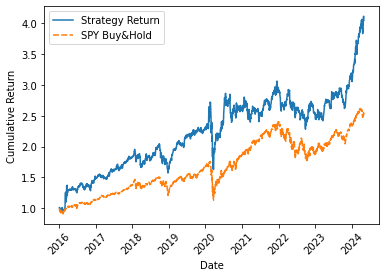

In [193]:
cum_returns_df = np.exp(np.log1p(comp_df).cumsum()) 

sns.lineplot(cum_returns_df)
plt.xticks(rotation=45)
plt.ylabel('Cumulative Return')
cum_returns_df.tail(10)